In [1]:
#imports
import pandas as pd
import numpy as np

#graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# no warnings
import warnings
warnings.filterwarnings('ignore')

## EDA

In [2]:
# import data (from https://archive.ics.uci.edu/ml/datasets/bank+marketing)
bank = pd.read_csv('bank-additional-full.csv', sep=';')
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
# describe numerical variables
num_var_description = bank.describe().transpose()[['count','mean','std','min','max']]
num_var_description

,count,mean,std,min,max
age,41188.0,40.024060,10.421250,17.000,98.000
duration,41188.0,258.285010,259.279249,0.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000
previous,41188.0,0.172963,0.494901,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5228.100


In [4]:
# no null values
np.all(bank.isnull().mean()==0)

True

Text(0, 0.5, '')

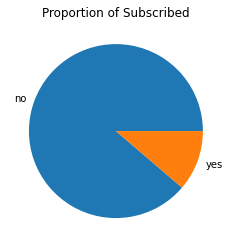

In [5]:
# 11% subscribed
bank['y'].value_counts(normalize=True).plot(kind='pie')
plt.title('Proportion of Subscribed')
plt.ylabel('')

In [6]:
# change y to binary variable
bank['y'] = bank['y'].apply(lambda x:x=='yes').astype(int)

In [7]:
# separate features to numerical and categorical
cat_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
num_features = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

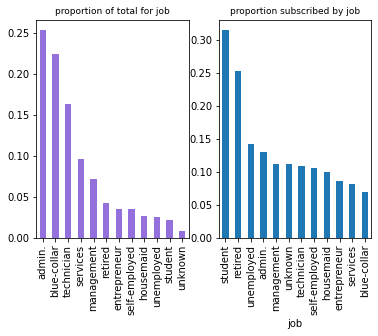

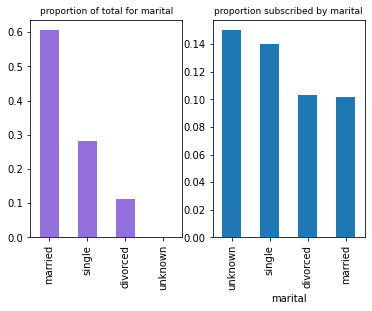

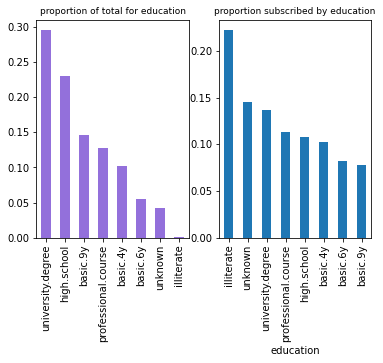

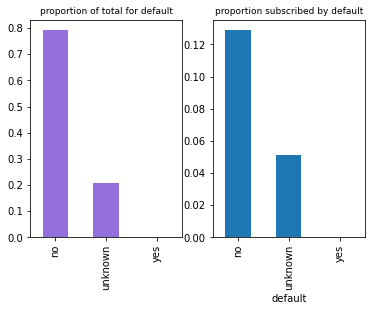

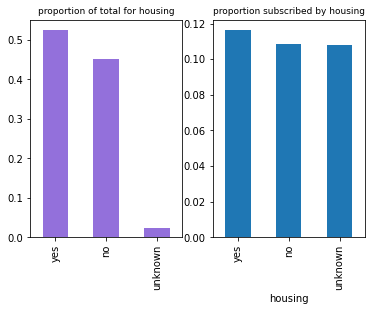

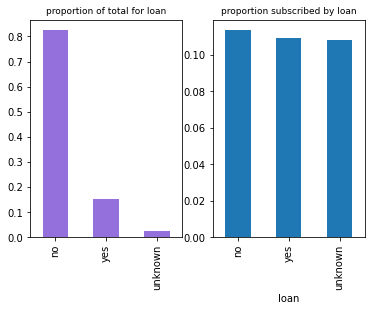

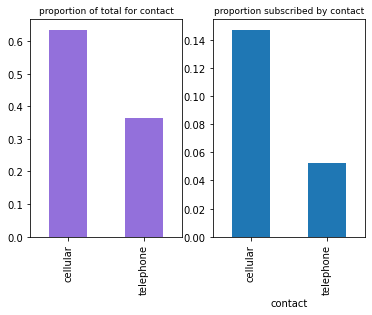

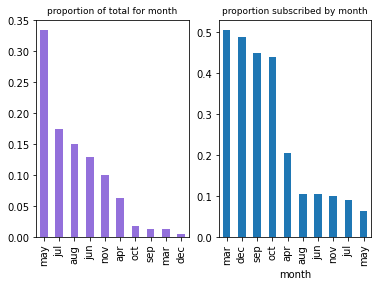

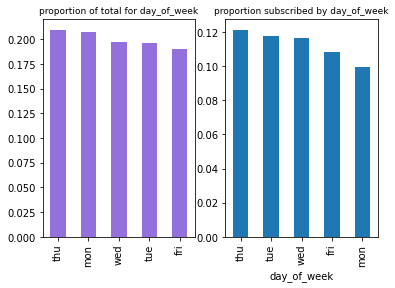

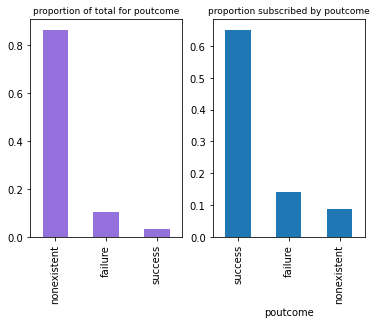

In [8]:
# graph normalized counts of each categorical feature's values and the poportion suscribed for each values
for c in cat_features:
    fig, axs = plt.subplots(1,2)
    bank[c].value_counts(normalize=True).sort_values(ascending=False).plot('bar',ax=axs[0],color='mediumpurple')
    axs[0].set_title('proportion of total for ' + c,{'fontsize':9})
    bank.groupby(c)['y'].mean().sort_values(ascending=False).plot('bar',ax=axs[1])
    axs[1].set_title('proportion subscribed by ' + c,{'fontsize':9})
    plt.show()

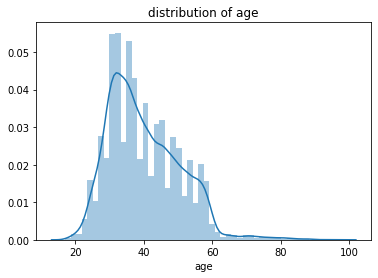

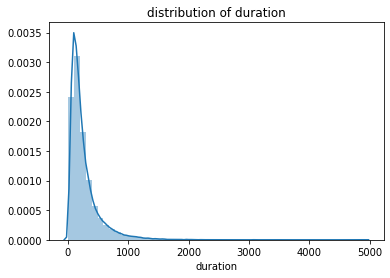

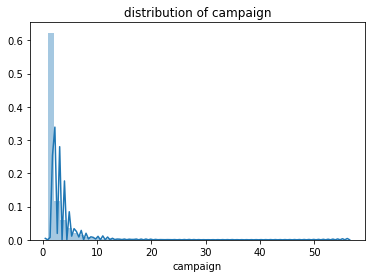

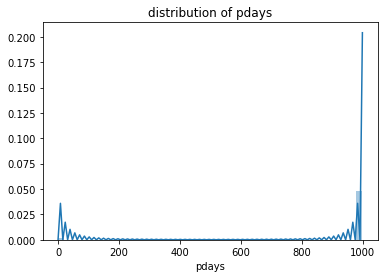

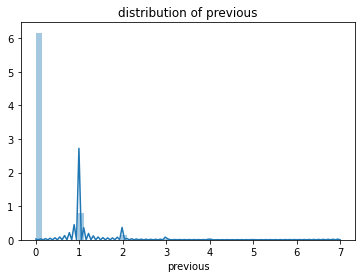

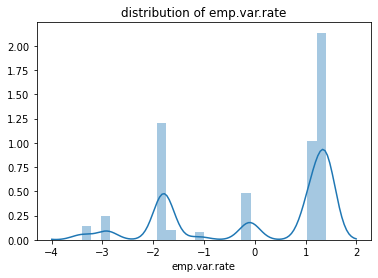

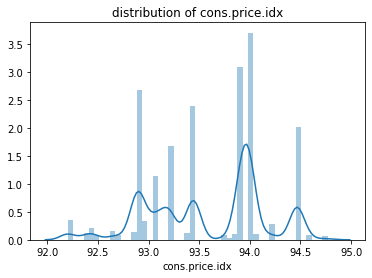

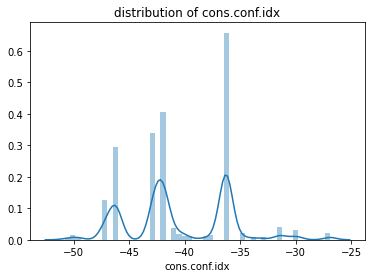

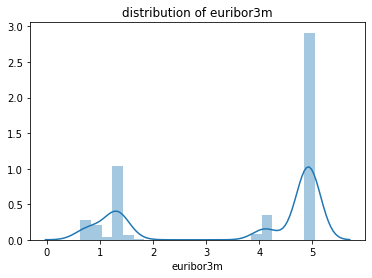

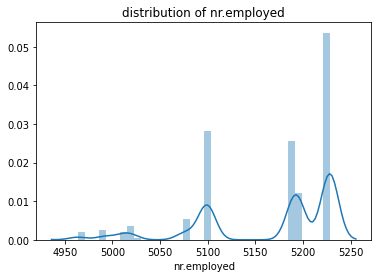

In [9]:
# plot distribution of numerical features
for n in num_features:
    sns.distplot(bank[n])
    plt.title("distribution of "+n)
    plt.show()

## Data Preprocessing

In [10]:
# function that does data preprocessing
def prep_data(df):
    # helper function for one hot encoding
    def create_one_hot(df,name):
        col = df[name]
        dct = {}
        col_values = col.unique()
        for v in col_values:
            dct["one_hot_" + name + "_" + v] = (col==v).astype(int)
        small_df = pd.DataFrame(dct)
        return pd.concat([df.drop(name,axis=1),small_df],axis=1)
    
    # one hot encode categorical columns
    one_hot_features = ['job','marital','default','housing','loan','contact','month','day_of_week','poutcome']
    for c in one_hot_features:
        df = create_one_hot(df,c)

    # helper function for ordinal encoding of education
    def educ(x):
        if x== 'unknown':
            return -1
        elif x== 'illiterate':
            return 0
        elif x=='basic.4y':
            return 1
        elif x== 'basic.6y':
            return 2
        elif x=='basic.9y':
            return 3
        elif x== 'high.school':
            return 4
        elif x== 'professional.course':
            return 5
        elif x== 'university.degree':
            return 6
        
    # ordinal encoding for education
    df['education_ord'] = df['education'].apply(educ)
    df = df.drop('education',axis=1)
    
    #helper functions to standarize columns
    def standardize(col):
        col_mean = df[col].mean()
        col_std = df[col].std()
        return (df[col]-col_mean)/col_std
    
    #standardize numerical variables
    num_features = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
    for n in num_features:
        df[n] = standardize(n)
        
    return df

In [11]:
# split to 70% training and 30% testing data
X = bank.drop('y',axis=1)
y = bank.y

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=234)
X_train_prepped = prep_data(X_train_)
X_test_prepped = prep_data(X_test_)

## Feature Selection

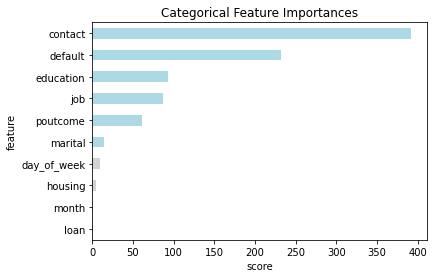

In [12]:
# transform categorical features to numerical
oe = OrdinalEncoder()
X_train_enc = oe.fit_transform(X_train_[cat_features])

# best categorical features are contact, default, education, job, poutcome, marital
fs = SelectKBest(chi2, k='all')
fs.fit(X_train_enc, y_train_)
colors = ['lightgrey']*4 + ['lightblue']*6 
pd.DataFrame({'feature':cat_features, 'score': fs.scores_}).sort_values(
    'score',ascending=True).plot(y='score',x='feature',kind='barh',color=colors, legend=False)
plt.title('Categorical Feature Importances')
plt.xlabel('score')
plt.savefig('images/feat_importance1.png',bbox_inches='tight')

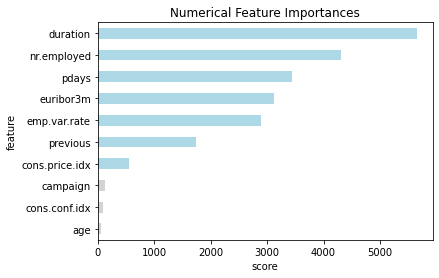

In [13]:
# best numerical features are duration, nr.employed, pdays, euribor3m, emp.var.rate, previous, cons.price.idx
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train_[num_features], y_train_)
colors = ['lightgrey']*3 + ['lightblue']*7
pd.DataFrame({'feature':num_features, 'score': fs.scores_}).sort_values(
    'score',ascending=True).plot(y='score',x='feature',kind='barh',color=colors,legend=False)
plt.title('Numerical Feature Importances')
plt.xlabel('score')
plt.savefig('images/feat_importance2.png',bbox_inches='tight')

In [14]:
# selected features
features = ['duration', 'nr.employed', 'pdays', 'euribor3m', 'emp.var.rate', 'previous', 'cons.price.idx'] + [
    x for x in X_train_prepped.columns if x.startswith('one_hot_contact') or x.startswith('one_hot_default') or 
    x.startswith('education_ord') or x.startswith('one_hot_poutcome') or x.startswith('one_hot_job') or 
    x.startswith('one_hot_marital')]

## Naive Bayes Classifier

In [15]:
# helper function to print f1 and accuracy score
def print_accuracy_f1(test,pred):
    # accuracy
    print("accuracy: " + str(accuracy_score(test, pred)))

    # f1 score
    print("f1-score: " + str(f1_score(test, pred)))

In [16]:
# fit/predict naives bayes with all features
clf = GaussianNB()
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.6529092821882334
f1-score: 0.3240346729708432


In [17]:
# fit/predict naives bayes with selected features
clf = GaussianNB()
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.7622400258962532
f1-score: 0.4156722354813048


In [18]:
## calculate precision/recall across thresholds
# predict probabilites
nb_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
nb_probs = nb_probs[:, 1]

# calculate auc
nb_precision, nb_recall, _ = precision_recall_curve(y_test_, nb_probs)
nb_auc = auc(nb_recall, nb_precision)
print("PR AUC: " + str(nb_auc))

PR AUC: 0.4350909146058854


## K Neighbors Classifier

In [19]:
# fit/predict with all features 
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.891964068948774
f1-score: 0.3043251693590412


In [20]:
# fit/predict with selected features 
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.8962531358744031
f1-score: 0.3721841332027424


In [21]:
## calculate precision/recall across thresholds
# predict probabilites
kn_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
kn_probs = kn_probs[:, 1]

# calculate auc
kn_precision, kn_recall, _ = precision_recall_curve(y_test_, kn_probs)
kn_auc = auc(kn_recall, kn_precision)
print("PR AUC: " + str(kn_auc))

PR AUC: 0.513162664547551


## Logistic Regression

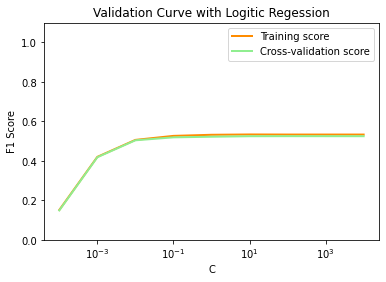

In [22]:
# tune C paramter and plot validation curve
param_range = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
train_scores, test_scores = validation_curve(
   LogisticRegression(), X_train_prepped, y_train_, param_name="C", param_range=param_range,
    scoring="f1", n_jobs=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Validation Curve with Logitic Regession")
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="lightgreen", lw=lw)
plt.legend(loc="best")
plt.savefig('images/lr_val.png',bbox_inches='tight')

In [23]:
# fit/predict with all features
clf = LogisticRegression(C=1)
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9016751638747269
f1-score: 0.41275978733687774


In [24]:
# fit/predict with selected features
clf = LogisticRegression(C=1)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9056405276361577
f1-score: 0.4854368932038835


In [25]:
## calculate precision/recall across thresholds
# predict probabilites
lr_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate auc
lr_precision, lr_recall, _ = precision_recall_curve(y_test_, lr_probs)
lr_auc = auc(lr_recall, lr_precision)
print("PR AUC: " + str(lr_auc))

PR AUC: 0.5640609076033491


## SVM

In [26]:
# load smaller dataset
bank_small = pd.read_csv('bank-additional.csv',sep=';')
X_small = prep_data(bank_small.drop('y',axis=1))
y_small = bank_small.y.apply(lambda x:x=='yes').astype(int)

In [ ]:
#tuning with all features and smaller dataset
parameters = {'C':[0.01,0.1,1,10,100],'kernel':['linear','poly','rbf']}
svc = SVC()
clf = GridSearchCV(svc, parameters,scoring='f1')
clf.fit(X_small, y_small)
clf.best_params_

In [27]:
# fit/predict with all features, tuned parameters
clf = SVC(C=10,kernel='linear')
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9019179412478757
f1-score: 0.40412979351032446


In [ ]:
#tuning with selected features and smaller dataset
parameters = {'C':[0.01,0.1,1,10,100],'kernel':['linear','poly','rbf']}
svc = SVC()
clf = GridSearchCV(svc, parameters,scoring='f1')
clf.fit(X_small[features], y_small)
clf.best_params_ 

In [28]:
# fit/predict with selected features, tuned parameters
clf = SVC(C=10,kernel='rbf',probability=True)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9058833050093065
f1-score: 0.4562879850397381


In [29]:
## calculate precision/recall across thresholds
# predict probabilites
svm_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]

# calculate auc
svm_precision, svm_recall, _ = precision_recall_curve(y_test_, svm_probs)
svm_auc = auc(svm_recall, svm_precision)
print("PR AUC: " + str(svm_auc))

PR AUC: 0.5774651683786911


## Decision Tree Classifier

In [ ]:
#tuning with all features
parameters = {'min_samples_split':[5,20,50,100],
              'max_depth':[4,6,8,10,12,14]}
clf = DecisionTreeClassifier()
clf = GridSearchCV(clf, parameters,scoring='f1')
clf.fit(X_train_prepped,y_train_)
clf.best_params_

In [30]:
# fit/predict with all features and tuned parameters
clf = DecisionTreeClassifier(max_depth=6,min_samples_split=100)
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.909686817188638
f1-score: 0.5687789799072642


In [31]:
# fit/predict with selected features and tuned parameters
clf = DecisionTreeClassifier(max_depth=6,min_samples_split=100)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.908877559278142
f1-score: 0.56015625


In [32]:
## calculate precision/recall across thresholds
# predict probabilites
dt_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
dt_probs = dt_probs[:, 1]

# calculate auc
dt_precision, dt_recall, _ = precision_recall_curve(y_test_, dt_probs)
dt_auc = auc(dt_recall, dt_precision)
print("PR AUC: " + str(dt_auc))

PR AUC: 0.574491016733935


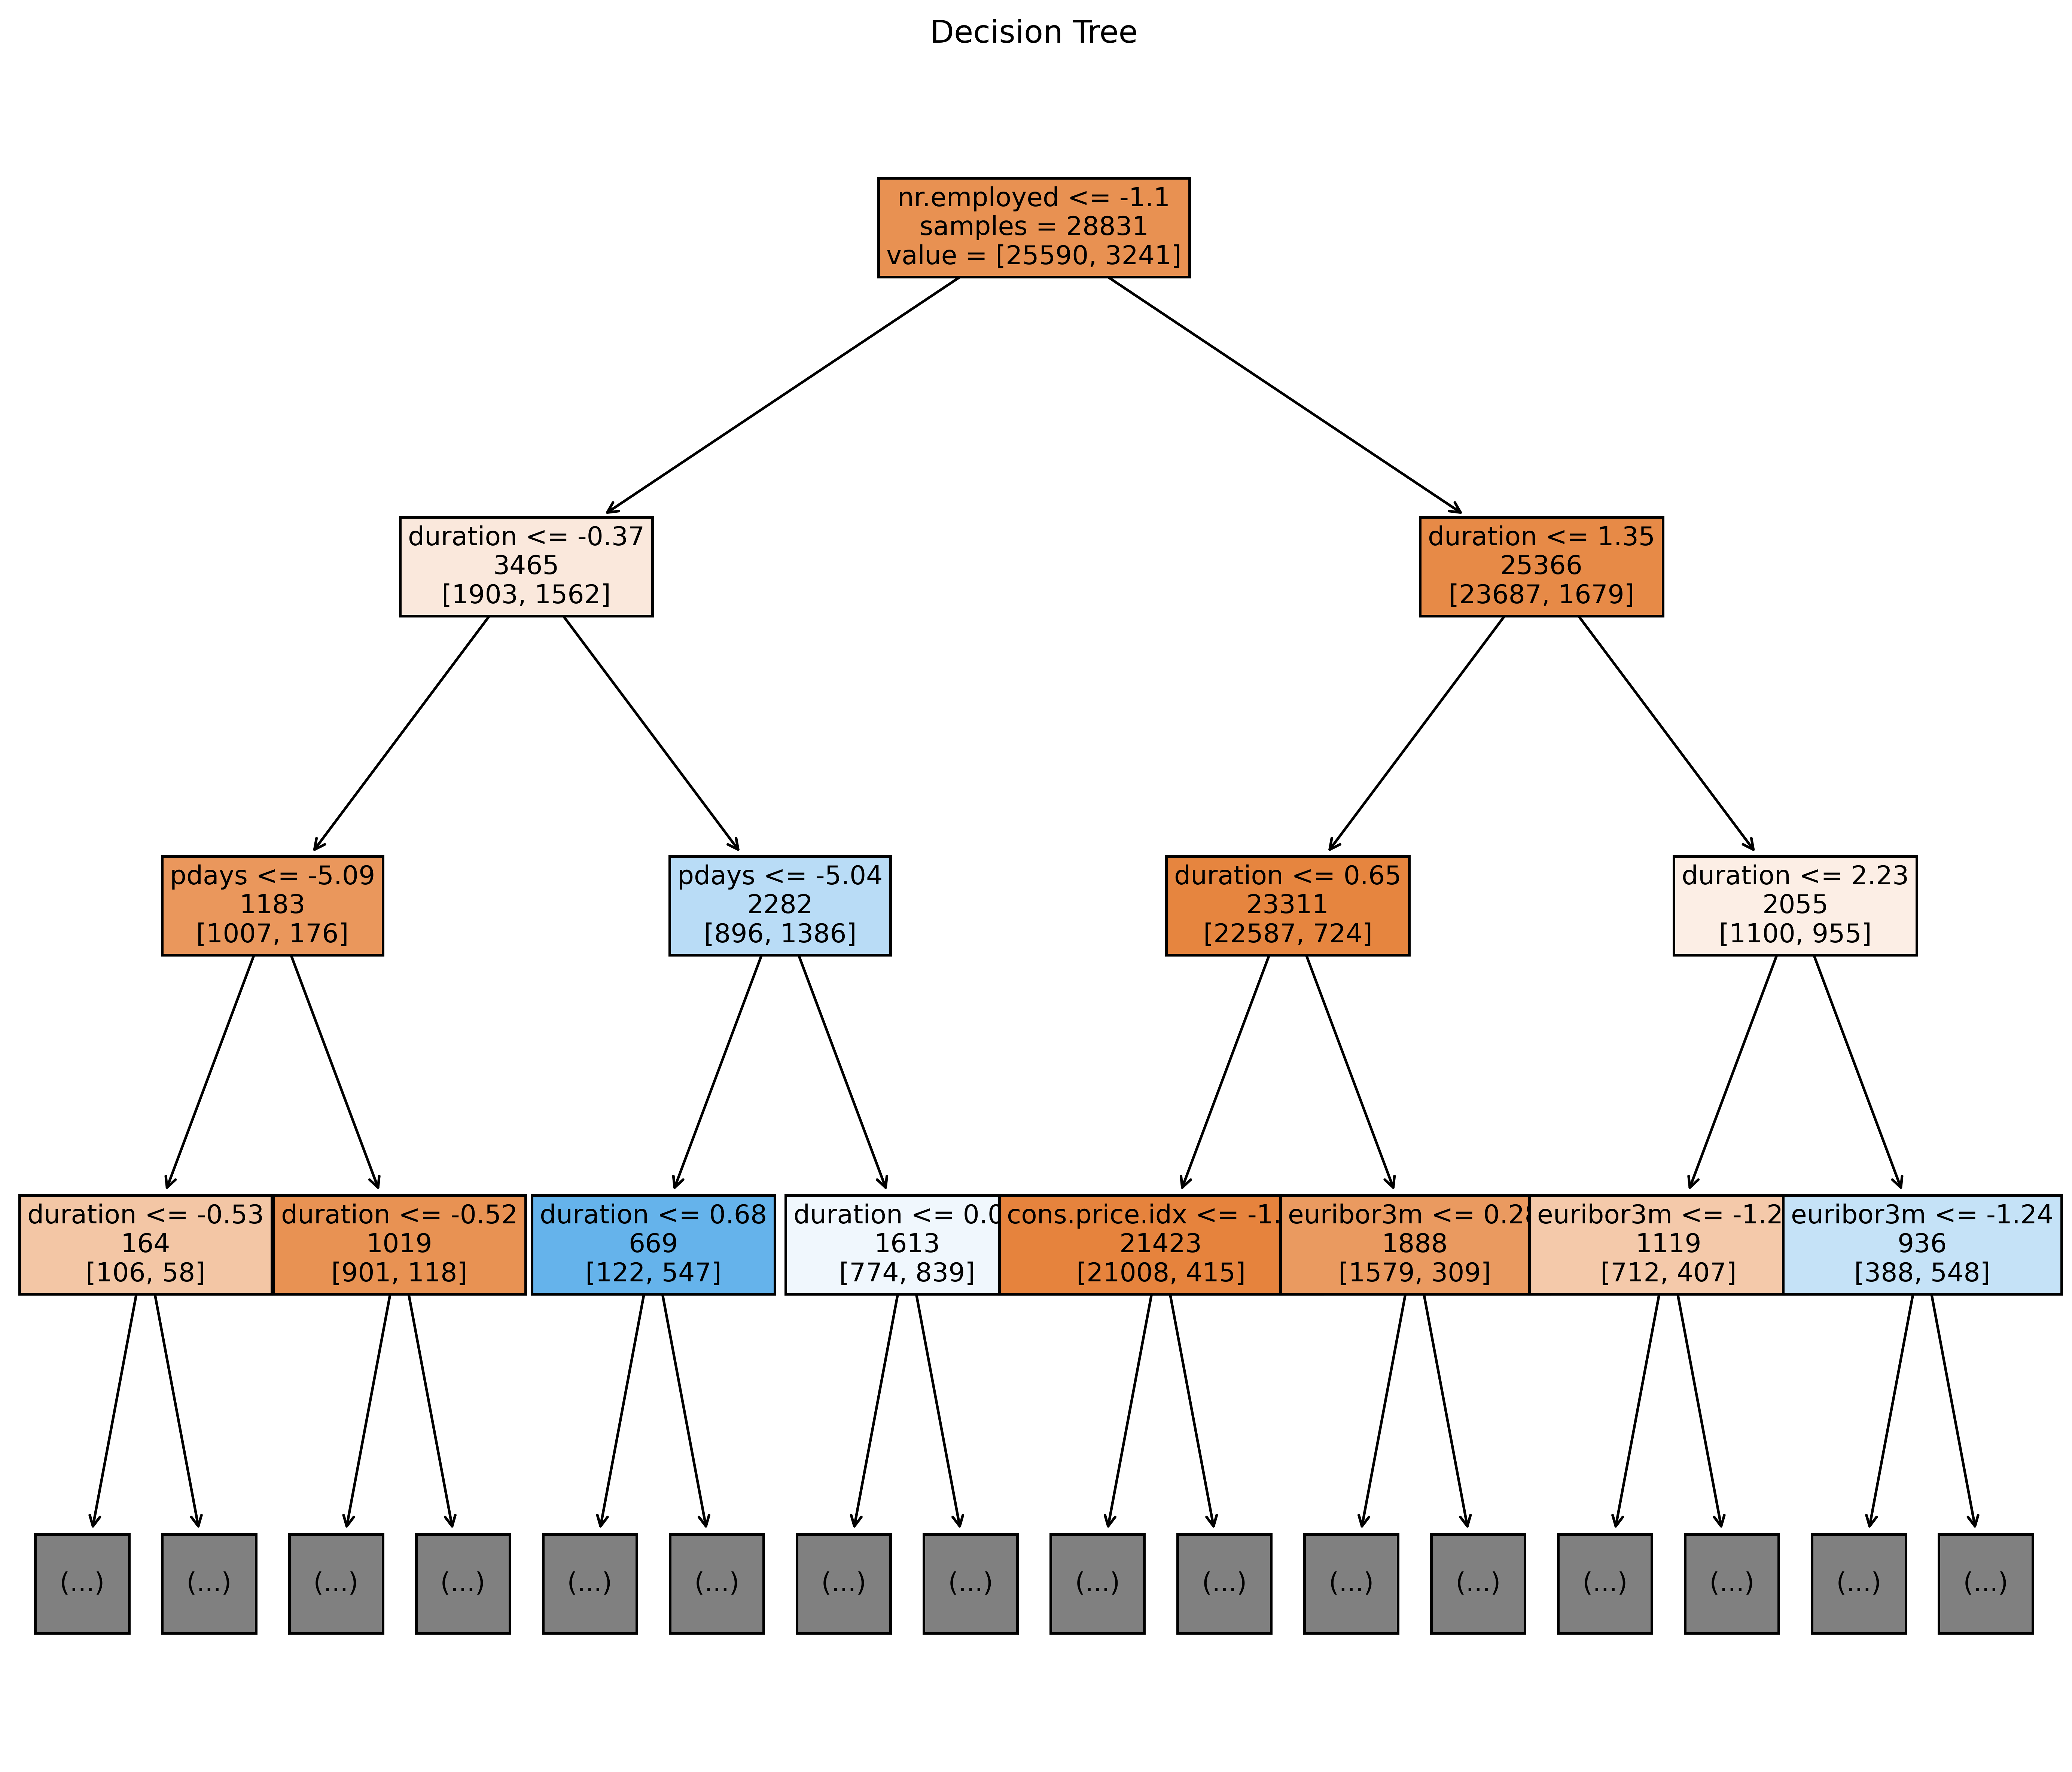

In [33]:
# plot decision tree
fig = plt.figure(figsize = (14,12), dpi=500)
tree.plot_tree(clf,feature_names = features,filled=True,fontsize=10,label='root',impurity=False, precision=2, max_depth=3)
plt.title("Decision Tree")
fig.savefig('images/dt.png',bbox_inches='tight')

## Random Forest Classifier

In [ ]:
#tuning with all features
parameters = {'min_samples_split':[5,20,50,100],
              'max_depth':[4,6,8,10,12,14]}
clf = RandomForestClassifier()
clf = GridSearchCV(clf, parameters,scoring='f1')
clf.fit(X_train_prepped,y_train_)
clf.best_params_

In [34]:
# fit/predict with all features and tuned parameters
clf =  RandomForestClassifier(max_depth=14,min_samples_split=50)
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9036173828599174
f1-score: 0.3654768247202983


In [35]:
# fit/predict with selected features and tuned parameters
clf = RandomForestClassifier(max_depth=14,min_samples_split=50)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9108197782633325
f1-score: 0.5145374449339207


In [36]:
## calculate precision/recall across thresholds
# predict probabilites
rf_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# calculate auc
rf_precision, rf_recall, _ = precision_recall_curve(y_test_, rf_probs)
rf_auc = auc(rf_recall, rf_precision)
print("PR AUC: " + str(rf_auc))

PR AUC: 0.63448585207472


## AdaBoost Classifier

In [ ]:
#tuning with all features
parameters = {'learning_rate': [0.01,0.1,1],
                   'n_estimators': [300]}
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6,min_samples_split=100))
clf = GridSearchCV(clf, parameters,scoring='f1')
clf.fit(X_train_prepped,y_train_)
clf.best_params_

In [37]:
# fit/predict with all features and tuned parameters
clf =AdaBoostClassifier(DecisionTreeClassifier(max_depth=6,min_samples_split=100), n_estimators=300, learning_rate=0.01)
clf.fit(X_train_prepped, y_train_)
y_pred = clf.predict(X_test_prepped)

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9066925629198025
f1-score: 0.5108188375053033


In [38]:
# fit/predict with selected features and tuned parameters
clf =AdaBoostClassifier(DecisionTreeClassifier(max_depth=6,min_samples_split=100), n_estimators=300, learning_rate=0.01)
clf.fit(X_train_prepped[features], y_train_)
y_pred = clf.predict(X_test_prepped[features])

# print metrics
print_accuracy_f1(y_test_,y_pred)

accuracy: 0.9104151493080845
f1-score: 0.5802047781569967


In [39]:
## calculate precision/recall across thresholds
# predict probabilites
ab_probs = clf.predict_proba(X_test_prepped[features])

# keep probabilities for the positive outcome only
ab_probs = ab_probs[:, 1]

# calculate auc
ab_precision, ab_recall, _ = precision_recall_curve(y_test_, ab_probs)
ab_auc = auc(ab_recall, ab_precision)
print("PR AUC: " + str(ab_auc))

PR AUC: 0.6100697527053143


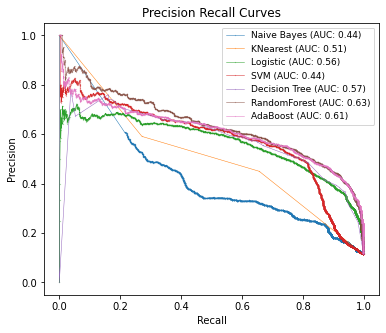

In [51]:
fig = plt.figure(figsize = (6,5))

# plot PR curve for all models
plt.plot(nb_recall, nb_precision, marker='.', label='Naive Bayes (AUC: %.2f)' % nb_auc, linewidth=0.5, markersize=0.3)
plt.plot(kn_recall, kn_precision, marker='.', label='KNearest (AUC: %.2f)' % kn_auc, linewidth=0.5, markersize=0.3)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic (AUC: %.2f)' % lr_auc, linewidth=0.5, markersize=0.3)
plt.plot(svm_recall, svm_precision, marker='.', label='SVM (AUC: %.2f)' % nb_auc, linewidth=0.5, markersize=0.3)
plt.plot(dt_recall, dt_precision, marker='.', label='Decision Tree (AUC: %.2f)' % dt_auc, linewidth=0.5, markersize=0.3)
plt.plot(rf_recall, rf_precision, marker='.', label='RandomForest (AUC: %.2f)' % rf_auc, linewidth=0.5, markersize=0.3)
plt.plot(ab_recall, ab_precision, marker='.', label='AdaBoost (AUC: %.2f)' % ab_auc, linewidth=0.5, markersize=0.3)

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curves')
# show the legend
plt.legend(loc=1, fontsize=9)
plt.savefig('images/prcurves.png',bbox_inches='tight')